In [79]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import fileinput

#Fit the code to the screen
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [4]:
#Reading the movies data
my_path = !pwd
movies_filename = "/ml-20/movies.csv"
dfmovies = pd.read_csv(my_path[0]+movies_filename, index_col=None, sep=',')

In [3]:
#Extract the year from the title
dfmovies["year"] = dfmovies['title'].apply(lambda x: x[x.rfind("(")+1:x.rfind(")")])
dfmovies["name"] = dfmovies['title'].apply(lambda x: x[:x.rfind("(")-1])
del dfmovies['title']
#Get the columns to the original order
cols = dfmovies.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[-2:-1] + cols[1:2]
dfmovies = dfmovies[cols]

In [82]:
#Reading the ratings data
ratings_filename = "/ml-20/ratings.csv"
dfratings = pd.read_csv(my_path[0]+ratings_filename, index_col=None, sep=',')

In [ ]:
#Check how many movies have enough ratings
ratings_num = []
movie_ids = (dfratings["movieId"]).unique()
for movie in movie_ids:
    ratings_num.append(dfratings[dfratings["movieId"] == movie].shape[0])

[175]


In [ ]:
#Create df of movies ids and ratings count
ratings_cnt = pd.DataFrame([movie_ids, ratings_num])
ratings_cnt = ratings_cnt.transpose()
ratings_cnt.columns = ["movieId", "ratingsCount"]

In [ ]:
with open(my_path[0]+'/explore/ratings_cnt.pik', 'wb') as handle:
    pickle.dump(ratings_cnt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [74]:
#Create df of user ids and ratings count
user_ratings_filename = "/ml-20/usersCnt.csv"
user_ratings_cnt = pd.read_csv(my_path[0]+user_ratings_filename, index_col=None, sep=',')

In [78]:
user_ratings_cnt["ratingsCount"].describe()
with open(my_path[0]+'/explore/user_ratings_cnt.pik', 'wb') as handle:
    pickle.dump(user_ratings_cnt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
(n, bins, patches) = plt.hist(ratings_cnt["ratingsCount"], bins=np.arange(1,1000, 100))
plt.show()

In [5]:
# Get movie and user ratings
ratings_cnt = pickle.load(open(my_path[0]+'/explore/ratings_cnt.pik', 'rb'))


count    138492.000000
mean        144.411879
std         230.267269
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: ratingsCount, dtype: float64

In [8]:
ratings_cnt["ratingsCount"].describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: ratingsCount, dtype: float64

346
193


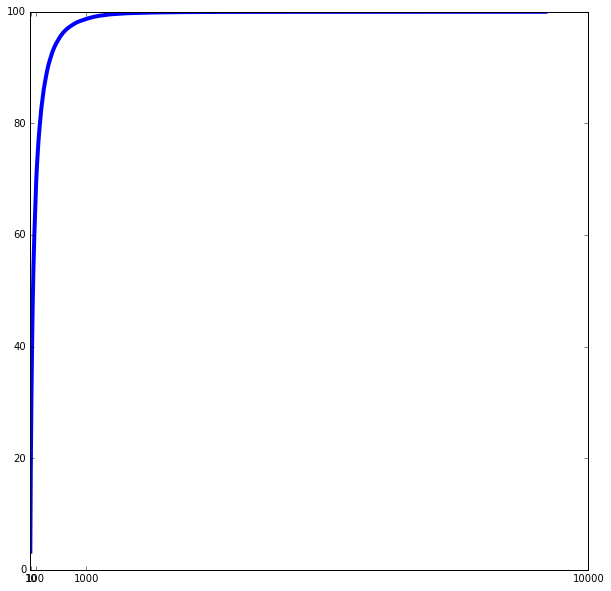

In [74]:
NUM_MOVIE_BINS = max(ratings_cnt["ratingsCount"])-min(ratings_cnt["ratingsCount"])

movie_counts, bin_edges = np.histogram(ratings_cnt["ratingsCount"], bins=NUM_MOVIE_BINS)
movie_cdf = np.cumsum(movie_counts,dtype=float)
movie_cdf_normalized = movie_cdf/max(movie_cdf)*100.0

#print user_cdf
CUTOFF_PERCENTILE = 80.0
for i in range(NUM_MOVIE_BINS):
    if movie_cdf_normalized[i] >= CUTOFF_PERCENTILE: 
        movie_cutoff = i+min(ratings_cnt["ratingsCount"])
        print movie_cutoff
        break
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
XMIN = 10.0
XMAX = 20000
plt.xlim(xmin=XMIN,xmax=XMAX)
plt.ylim(ymin=0.0,ymax=105)
plt.plot(movie_cdf_normalized,linewidth=3,linestyle="-",color="#008000")
ax.set_title("MovieLens 20M: Movie Ratings",fontsize=18)
ax.set_xlabel("Ratings",fontsize=14)
ax.set_ylabel("Fraction(%)",fontsize=14)
ax.text(movie_cutoff-10,CUTOFF_PERCENTILE-2,str(movie_cutoff),color="#ff0000")
ax.set_xscale('symlog', basex=10)
plt.plot([XMIN, XMAX], [CUTOFF_PERCENTILE, CUTOFF_PERCENTILE], linewidth=1, linestyle="--",color="#ff0000")

plt.xticks([10,100,1000,10000],["10","100","1000","10000"])
plt.savefig("movies_histogram.pdf",dpi=200)
plt.clf()
plt.cla()
filtered_movie_ratings_cnt = ratings_cnt[ratings_cnt["ratingsCount"]>=movie_cutoff]



In [153]:
# Filtering the users using the filtered movies 
userId = "1"
counter = 0
userIdList = []
ratingList = []
filtered_movie_ids = set(filtered_movie_ratings_cnt["movieId"])
filtered_movie_ratings_cnt["movieId"]
for line in fileinput.input(my_path[0]+ratings_filename):
    if line.find("Id")>=0:
        continue
    lineUserId = line.split(",")[0]
    lineMovieId = int(line.split(",")[1])
    if userId != lineUserId:
        userIdList.append(userId)
        ratingList.append(counter)
        userId = lineUserId
        counter = 0
    if lineMovieId in filtered_movie_ids:    
        counter+=1     
userIdList.append(userId)
ratingList.append(counter)
user_ratings_cnt = pd.DataFrame([userIdList,ratingList])
user_ratings_cnt = user_ratings_cnt.transpose()
user_ratings_cnt.columns=["userId","ratingsCount"]
fileinput.close()

In [161]:
with open(my_path[0]+'/explore/user_ratings_cnt.pik', 'wb') as handle:
    pickle.dump(user_ratings_cnt, handle, protocol=pickle.HIGHEST_PROTOCOL)
user_ratings_cnt.describe()

,userId,ratingsCount
count,138493,138493
unique,138493,1718
top,44924,20
freq,1,4462


188


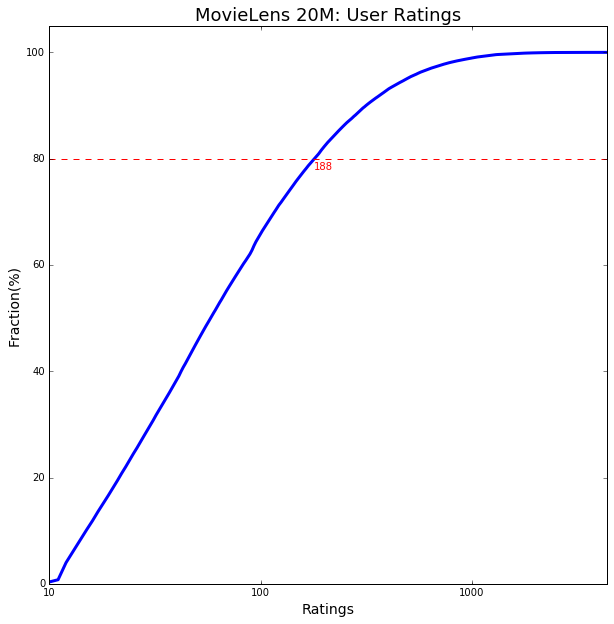

In [162]:
user_ratings_cnt = pickle.load(open(my_path[0]+'/explore/user_ratings_cnt.pik', 'rb'))
NUM_USER_BINS = max(user_ratings_cnt["ratingsCount"])-min(user_ratings_cnt["ratingsCount"])
user_counts, bin_edges = np.histogram(user_ratings_cnt["ratingsCount"], bins=NUM_USER_BINS,density=True)
user_cdf = np.cumsum(user_counts,dtype=float)        
user_cdf_normalized = user_cdf/max(user_cdf)*100.0

for i in range(NUM_USER_BINS):
    if user_cdf_normalized[i] >= CUTOFF_PERCENTILE: 
        user_cutoff = i+min(user_ratings_cnt["ratingsCount"])
        print user_cutoff
        break

        
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
XMIN = 10.0
XMAX = len(user_cdf_normalized)
plt.xlim(xmin=XMIN,xmax=XMAX)
plt.ylim(ymin=0.0,ymax=105)
plt.plot(user_cdf_normalized,linewidth=3,linestyle="-",color="#0000ff")
ax.set_title("MovieLens 20M: User Ratings",fontsize=18)
ax.set_xlabel("Ratings",fontsize=14)
ax.set_ylabel("Fraction(%)",fontsize=14)
ax.text(user_cutoff-10,CUTOFF_PERCENTILE-2,str(user_cutoff),color="#ff0000")
ax.set_xscale('symlog', basex=10)
plt.plot([XMIN, XMAX], [CUTOFF_PERCENTILE, CUTOFF_PERCENTILE], linewidth=1, linestyle="--",color="#ff0000")

plt.xticks([10,100,1000],["10","100","1000"])
plt.savefig("user_histogram.pdf",dpi=200)


In [163]:
filtered_movie_ratings_cnt = ratings_cnt[ratings_cnt["ratingsCount"]>=movie_cutoff]
filtered_user_ratings_cnt = user_ratings_cnt[user_ratings_cnt["ratingsCount"]>=user_cutoff]
with open(my_path[0]+'/explore/filtered_movie_ratings_cnt.pik', 'wb') as handle:
    pickle.dump(filtered_movie_ratings_cnt, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(my_path[0]+'/explore/filtered_user_ratings_cnt.pik', 'wb') as handle:
    pickle.dump(filtered_user_ratings_cnt, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [75]:
user_ratings_cnt

,userId,ratingsCount
0,1,175
1,2,61
2,3,187
3,4,28
4,5,66
5,6,24
6,7,276
7,8,70
8,9,35
9,10,38


In [108]:
fileinput.close()    